<a href="https://colab.research.google.com/github/SandraOelschlegel/dotfiles/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

**Exercise objetives**
- Use a pretrained neural network : Transfer learning

#### Transfer what?
We have seen that the convolutions are mathematical operation that detect specific patterns in input images and use them to classify the image. One could imagine that these patterns are not 100% specific to the task but to the input images. 

💡 Therefore, **why not using convolutions that have been learnt on other task** with the expectation that it will also work in other scenario?  We _transfer_ a CNN from one task to another => _transfer learning_. This has two advantages:
- taking less time to train
- benefiting from complex architecture that have been trained for state-of-the-art challenges. 

⚠️ Although convolutions may not be specific, the last layer is by design specific to the problem it was trained on! Therefore, this last layer is usually removed, replace by a layer that is design to the task. As this new last layer has random weight, it has to be retrained. This is called _fine-tunning_. 

#### VGG16
In this exercise, we will use the [VGG-16 Neural Network](https://neurohive.io/en/popular-networks/vgg16/), a well-known architecture that has been trained on ImageNet which is a very large database of images of different categories. In a nutshell, this architecture has already learnt kernels which are supposed to be good not only for the task it has been train on but maybe for other tasks. 

<center><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width=400></center>

The idea is that first layers are not specialized for the particular task it has been trained on ; only the last ones are. Therefore, we will 
- load the existing VGG16 network
- remove the last fully connected layers
- replace them by new connected layers (whose weights are randomly set)
- and train these last layers on a specific classification task - here, separate types of flower. 

The underlying idea is that the first convolutional layers of VGG-16, that has already been trained, corresponds to filters that are able to extract meaning features from images. And you will only learn the last layers for your particular problem.

<hr>
<hr>

# 1. Data loading & Preprocessing

You have two options to load the data on Google Colab.


**Option 1: Loading the data directly**

You can first get the data onto google Colab thanks to:

`!wget https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip`,

and then run 

`!unzip flowers-dataset.zip`

This is a very easy option to load the data into your working directory.

**Option 2: Adding the data to Google Drive.**

You can first download the data  from `https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip`. Then you have to add them to your Google Drive in a folder called `Deep_learning_data` (for instance) and run the following code in the notebook.: 

```
from google.colab import drive
drive.mount('/content/drive/')
```

The previous code will ask you to go to a given webpage where you copy the link and past it in the Colab form that will appear. Do so to load the data on Google Colab.

Why choosing this option over the first one? This can be of interest if you work in a project team, and update the data from time to time. By doing this, you can share the same data folder within a team, and be sure that everyone has the same at any time, even though someone changes it. The drawback is that Google Colab has now access to your Google Folder, which you might not be or not in favor of, depending on your sensibility.


❓ **Question** ❓ Use one of the above method to load your data

In [1]:
option_1 = True # Choose here

if option_1:
    !wget https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
    !unzip flowers-dataset.zip
else:
    from google.colab import drive
    drive.mount('/content/drive/')

--2021-05-19 14:26:59--  https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.52.233
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.52.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104983809 (100M) [application/zip]
Saving to: ‘flowers-dataset.zip’

flowers-dataset.zip 100%[===================>] 100.12M  11.3MB/s    in 11s     

2021-05-19 14:27:12 (9.16 MB/s) - ‘flowers-dataset.zip’ saved [104983809/104983809]

Archive:  flowers-dataset.zip
  inflating: flowers/daisy/2607132536_d95198e619_n.jpg  
  inflating: flowers/daisy/6480809771_b1e14c5cc2_m.jpg  
  inflating: flowers/daisy/9350942387_5b1d043c26_n.jpg  
  inflating: flowers/daisy/4065883015_4bb6010cb7_n.jpg  
  inflating: flowers/daisy/7924174040_444d5bbb8a.jpg  
  inflating: flowers/daisy/8740807508_0587f5b7b7.jpg  
  inflating: flo

❓ **Question** ❓ Use the following method to create 
`X_train, y_train, X_val, y_val, X_test, y_test, num_classes` depending on the `loading_method` you have used

In [2]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

def load_flowers_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/Deep_learning_data/flowers'
    elif loading_method == 'direct':
        data_path = 'flowers/'
    classes = {'daisy':0, 'dandelion':1, 'rose':2}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [3]:
# CALL load_flowers_data WITH YOUR PREFERRED METHOD HERE
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data('direct')



100%|██████████| 299/299 [00:01<00:00, 196.46it/s]


❓ Check image shape and plot few of them

In [4]:
X_train.shape, y_train.shape, y_train

((571, 256, 256, 3), (571, 3), array([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]], dtype=float32))

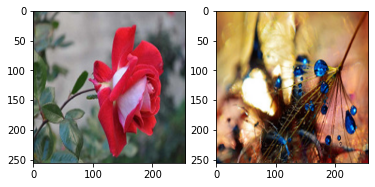

In [5]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(X_train[0]);
plt.subplot(1,2,2)
plt.imshow(X_train[1]);

# 2. Home made model

First, let's check our performance on a home-made CNN model

❓ **Questions** ❓ 

- Build, compile and fit a CNN model adapted to the challenge.
- Compare performance with baseline 
- We recommand to use the following architecture

---
```python
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = Sequential()

# Notice this cool new layer that "pipe" your rescaling within the architecture
model.add(Rescaling(1./255, input_shape=(256,256,3)))

# Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
```
---

In [6]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import regularizers, Sequential, layers

model = Sequential()
 
# Notice this cool new layer that "pipe" your rescaling within the architecture
model.add(Rescaling(1./255, input_shape=(256,256,3)))
 
# Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
model.add(layers.MaxPooling2D(3))
 
model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
model.add(layers.MaxPooling2D(3))
 
model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
model.add(layers.MaxPooling2D(3))
 
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping()

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,  
                    batch_size=16, 
                    verbose=1,
                  callbacks = [es])

Epoch 1/5
36/36 [==============================] - 33s 88ms/step - loss: 1.1461 - accuracy: 0.3786 - val_loss: 1.0888 - val_accuracy: 0.3520
Epoch 2/5
36/36 [==============================] - 2s 53ms/step - loss: 1.0479 - accuracy: 0.4261 - val_loss: 0.9308 - val_accuracy: 0.4749
Epoch 3/5
36/36 [==============================] - 2s 52ms/step - loss: 0.9024 - accuracy: 0.5205 - val_loss: 0.8998 - val_accuracy: 0.4916
Epoch 4/5
36/36 [==============================] - 2s 52ms/step - loss: 0.9089 - accuracy: 0.5688 - val_loss: 0.8071 - val_accuracy: 0.5419
Epoch 5/5
36/36 [==============================] - 2s 51ms/step - loss: 0.7613 - accuracy: 0.6665 - val_loss: 0.7715 - val_accuracy: 0.7318


In [ ]:
model.evaluate(X_test, y_test)[1]

# 3. Transfer learning

## 3.1 Load VGG16 model


❓ **Question** ❓ Write a first function `load_model()` that loads the pretrained VGG-16 model from `tensorflow.keras.applications.vgg16`. Especially, look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16) to load the model where:
- the `weights` have been learnt on `imagenet`
- the `input_shape` corresponds to the input shape of any of your images - you have to resize them in case they are not of the same size
- the `include_top` argument is set to `False` in order not to load the fully-connected layers of the VGG-16 without the last layer which was specifically trained on `imagenet`

❗ **Remark** ❗ Do not change the default value of the other arguments

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    
    model = VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(256,256,3), pooling=None, classes=1000,
    classifier_activation='softmax')
    
    return model
    

❓ **Question** ❓ Look at the architecture of the model thanks to the summary method

In [9]:
model = load_model()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png">

Impressive, right? Two things to notice:
- It ends with a convolution layer (namely a maxpooling layer that is the layer that follows a convolution). The flattening of the output and the fully connected layers are not here yet! We need to add them !
- There are more than 14.000.000 parameters, which is a lot. We could fine-tune them, meaning update them as we will update the last layers weights, but it will take a lot of time. For that reason, we will inform the model that the layers until the flattening are non-trainable.

❓ **Question** ❓ Write a first function that takes the previous model as input the set the first layers to be non-trainable, by applying `model.trainable = False`. Then check-out the summary of the model to see that now, the parameters are `non-trainable`



In [29]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.layers.trainable = False
    return model

In [30]:
model = set_nontrainable_layers(model)

AttributeError: ignored

In [31]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
8*8*512

32768

❓ **Question** ❓ We will write a function that adds flattening and dense layers after the first convolutional layers. To do so, cannot directly use the classic `layers.Sequential()` instantiation.

For that reason, we will see another one here. The idea is that we define each layer (or group of layers) separately. Then, we concatenate them. See this example : 

---
```python
base_model = load_model()
base_model = set_nontrainable_layers(base_model)
flattening_layer = layers.Flatten()
dense_layer = layers.Dense(SOME_NUMBER_1, activation='relu')
prediction_layer = layers.Dense(SOME_NUMBER_2, activation='APPROPRIATE_ACTIVATION')

model = tf.keras.Sequential([
  base_model,
  flattening_layer,
  dense_layer,
  prediction_layer
])

```
---
The first line loads a group of layer which is the previous VGG-16 model. Then, we set this layers to be non-tranable. Then, we can instantiate as many layers as we want.

Finally, we use the `Sequential` with the sequence of layers that will correspond to our overall neural network. 

Replicate the following steps by adding a flattening and two dense layers (the first with 500 neurons) to the previous VGG-16 model.

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')
    
    model = tf.keras.Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])
    return model

❓ **Question** ❓ Now look at the layers and parameters of your model. Note that there is a distinction, at the end, between the trainable and non-trainable parameters

In [20]:
model = add_last_layers(model)
model.summary()

AttributeError: ignored

❓ **Question** ❓ Write a function that build (and compile) your model - we advise Adam with `learning_rate=1e-4`. 

In [32]:
from tensorflow.keras import optimizers

def build_model():
    model = load_model()
    model = set_nontrainable_layers(model)
    model = add_last_layers(model)
    
    opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001)

    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
    return model

## 3.2 Back to the data

The VGG16 model was trained on images which were preprocessed in a specific way. This is the reason why we did not normalized them earlier.

❓ **Question** ❓ Apply this processing to the original (non-normalized) images here using the method `preprocess_input` that you can import from `tensorflow.keras.applications.vgg16`. See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input).

In [22]:
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train = tf.keras.applications.vgg16.preprocess_input(
    X_train, data_format=None)
X_test = tf.keras.applications.vgg16.preprocess_input(
    X_test, data_format=None)
X_val = tf.keras.applications.vgg16.preprocess_input(
    X_val, data_format=None)

In [23]:
X_train.shape, X_test.shape, X_val.shape

((571, 256, 256, 3), (149, 256, 256, 3), (179, 256, 256, 3))

## 3.3 Fit the model

❓ **Question** ❓ Now estimate the model, with an early stopping criterion on the validation accuracy - here, the validation data are provided, therefore use `validation_data` instead of `validation_split`.

❗ **Remark** ❗ Store the results in a `history` variable

In [24]:
model = build_model()
model.summary()

AttributeError: ignored

In [33]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,  
                    batch_size=16, 
                    verbose=1,
                    callbacks = [es])

RuntimeError: ignored

❓ **Question** ❓ Plot the accuracy for the test and validation set using the usual function below

In [26]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
# YOUR CODE HERE

❓ **Question** ❓ Evaluate the model accuracy on the test set. Did we improve?

In [27]:
model.evaluate(X_test, y_test, verbose=0)[1]

RuntimeError: ignored

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9ed3c87450>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ed3c270d0>)

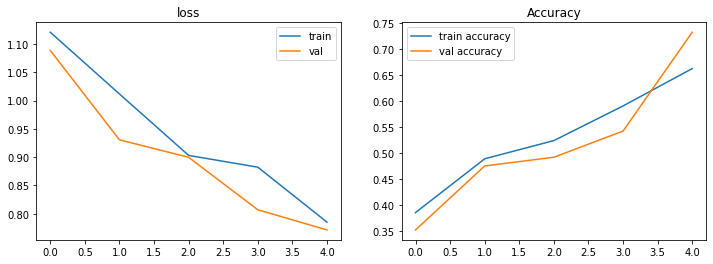

In [28]:
plot_history(history, title='', axs=None, exp_name="")

# (OPTIONAL). Improve the model

You can here try to improve the model test accuracy. To do that, here are some options you can consider

1. **Unfreeze and finetune**: As per [Google tutorial](https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning) 
>_Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate. This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind. It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features. It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way._


1. Add **data augmentation** if your model is overfitting. 

1. If your model is not - unlikely here - , try a more complex model.

1. Perform precise **grid search** on all the hyper-parameters: learning_rate, batch_size, data augmentation etc...

1. **Change the base model** to more modern one (resnet, efficient net1. available in the keras library

1. Curate the data: maintaining a sane data set is one of the keys to success.

1. Obtain more data

## 🏁 Congratulation 🏁 
Copy this notebook from your google drive into your local data-challenge repo, and commit+push your progress on github. To find where this Colab notebook has been save, click on `File --> Locate in Drive`.